## 指針  
1. 外れ値の除去
2. 線形回帰  
3. 残差に対してLightGBM 
4. model_1のmodel_2の予測値を合計して真の予測値とする

## 結果  
Ⅰ.    
外れ値：除去済み  
model_1：線形回帰モデル  
　特徴量：MidInc  
model_2:LightGBM(ハイパラ探索なし)  
　特徴量：緯度、経度  
y_test_pred = y_test_pred_model1 + y_test_pred_model2  

#### RMSE=0.4429721994055583  
　※線形回帰+LightGBM…0.5231193804756671より低い  

y_residual_test_2(残差)の平均は0

In [1]:
import sklearn.datasets
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as gbm

In [3]:
california = sklearn.datasets.fetch_california_housing()
feature = california.data
target = california.target

In [4]:
df = pd.DataFrame(feature, columns=california.feature_names)
df['target'] = target

### 外れ値の除去

In [5]:
#パーセンタイル点の獲得
df.quantile(q=[0.25,0.50,0.75])

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0.25,2.56340,18.0,4.440716,1.006079,787.0,2.429741,33.93,-121.80,1.19600
0.50,3.53480,29.0,5.229129,1.048780,1166.0,2.818116,34.26,-118.49,1.79700
0.75,4.74325,37.0,6.052381,1.099526,1725.0,3.282261,37.71,-118.01,2.64725


In [6]:
#四分位範囲
iqr = df.quantile(0.75) - df.quantile(0.25)
#上側外れ値
upper_outlier = df.quantile(0.75) + iqr * 1.5
#下側外れ値
downer_outlier = df.quantile(0.25) - iqr * 1.5

In [7]:
#3…二つの条件を満たす行を抽出
df_2 = df[~(df<=downer_outlier) & ~(df>=upper_outlier)].dropna()
df_2

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
...,...,...,...,...,...,...,...,...,...
20634,3.7125,28.0,6.779070,1.148256,1041.0,3.026163,39.27,-121.56,1.168
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [8]:
#ホールドアウト法…7:3
x_train, x_test, y_train, y_test = train_test_split(df_2.loc[:,'MedInc':'Longitude'], df_2['target'], 
                                                    train_size=0.7, 
                                                    shuffle=True, 
                                                    random_state=0)

In [9]:
x_train

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14416,3.1838,20.0,3.783465,1.094488,525.0,2.066929,32.79,-117.24
2727,1.2750,23.0,4.541114,1.068966,1370.0,3.633952,32.79,-115.54
2043,4.4583,25.0,7.830986,1.112676,249.0,3.507042,36.71,-119.69
4185,4.5766,34.0,4.200000,1.027586,407.0,2.806897,34.13,-118.23
5701,5.5362,30.0,5.498667,1.056000,1089.0,2.904000,34.22,-118.25
...,...,...,...,...,...,...,...,...
16713,2.9250,26.0,5.283525,1.093870,1291.0,2.473180,35.52,-120.69
3985,5.6163,33.0,6.419149,1.051064,1423.0,3.027660,34.19,-118.64
12667,3.0625,12.0,5.351163,1.081395,2299.0,2.673256,38.48,-121.43
13817,2.6827,17.0,5.376667,1.086667,765.0,2.550000,34.46,-117.12


In [10]:
y_train

14416    2.458
2727     0.604
2043     1.083
4185     1.858
5701     3.012
         ...  
16713    1.814
3985     2.484
12667    0.905
13817    1.104
3321     0.778
Name: target, Length: 11417, dtype: float64

In [13]:
#外れ値除去後のMedIncとtargetの相関は0.631
#外れ値を除去しても高い
pd.concat([x_train, y_train], axis=1).corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
MedInc,1.000000,-0.186107,0.698704,-0.255412,0.004417,-0.029786,-0.075094,-0.014665,0.631434
HouseAge,-0.186107,1.000000,-0.214873,-0.063684,-0.269227,-0.002596,-0.004867,-0.078425,0.084095
AveRooms,0.698704,-0.214873,1.000000,-0.003458,-0.064938,0.059336,0.132734,-0.091308,0.258946
AveBedrms,-0.255412,-0.063684,-0.003458,1.000000,0.069340,-0.090283,0.036401,-0.005442,-0.093747
Population,0.004417,-0.269227,-0.064938,0.069340,1.000000,0.210290,-0.111817,0.102053,0.004141
AveOccup,-0.029786,-0.002596,0.059336,-0.090283,0.210290,1.000000,-0.167768,0.186721,-0.271019
Latitude,-0.075094,-0.004867,0.132734,0.036401,-0.111817,-0.167768,1.000000,-0.933356,-0.147001
Longitude,-0.014665,-0.078425,-0.091308,-0.005442,0.102053,0.186721,-0.933356,1.000000,-0.045245
target,0.631434,0.084095,0.258946,-0.093747,0.004141,-0.271019,-0.147001,-0.045245,1.000000


### model1 線形回帰モデル  
※特徴量はMedIncのみ

In [14]:
#特徴量生成
x_train_medinc = x_train['MedInc']

In [19]:
#model_1
#線形回帰
model_1 = LinearRegression()
model_1.fit(x_train_medinc.values.reshape(-1,1), y_train)

LinearRegression()

In [22]:
y_train_pred_model1 = model_1.predict(x_train_medinc.values.reshape(-1,1))

In [26]:
#残差の出力
y_residual_1 = y_train - y_train_pred_model1

In [29]:
pd.concat([x_train, y_residual_1], axis=1).corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
MedInc,1.000000e+00,-0.186107,0.698704,-0.255412,0.004417,-0.029786,-0.075094,-0.014665,2.458974e-16
HouseAge,-1.861070e-01,1.000000,-0.214873,-0.063684,-0.269227,-0.002596,-0.004867,-0.078425,2.599965e-01
AveRooms,6.987036e-01,-0.214873,1.000000,-0.003458,-0.064938,0.059336,0.132734,-0.091308,-2.350171e-01
AveBedrms,-2.554122e-01,-0.063684,-0.003458,1.000000,0.069340,-0.090283,0.036401,-0.005442,8.708554e-02
Population,4.417234e-03,-0.269227,-0.064938,0.069340,1.000000,0.210290,-0.111817,0.102053,1.743189e-03
AveOccup,-2.978573e-02,-0.002596,0.059336,-0.090283,0.210290,1.000000,-0.167768,0.186721,-3.252541e-01
Latitude,-7.509380e-02,-0.004867,0.132734,0.036401,-0.111817,-0.167768,1.000000,-0.933356,-1.284249e-01
Longitude,-1.466493e-02,-0.078425,-0.091308,-0.005442,0.102053,0.186721,-0.933356,1.000000,-4.640724e-02
target,2.458974e-16,0.259997,-0.235017,0.087086,0.001743,-0.325254,-0.128425,-0.046407,1.000000e+00


### model2 LightGBM  
※特徴量は緯度と経度

In [31]:
lgbm = gbm.LGBMRegressor()
lgbm.fit(x_train[['Latitude','Longitude']], y_residual_1)

LGBMRegressor()

In [32]:
y_train_pred_model2 = lgbm.predict(x_train[['Latitude','Longitude']])

In [37]:
#残差２の出力
y_residual_2 = y_residual_1 - y_train_pred_model2
pd.concat([x_train.loc[:,'HouseAge':'AveOccup'], y_residual_2], axis=1).corr()

,HouseAge,AveRooms,AveBedrms,Population,AveOccup,target
HouseAge,1.000000,-0.214873,-0.063684,-0.269227,-0.002596,0.020630
AveRooms,-0.214873,1.000000,-0.003458,-0.064938,0.059336,-0.110030
AveBedrms,-0.063684,-0.003458,1.000000,0.069340,-0.090283,0.126300
Population,-0.269227,-0.064938,0.069340,1.000000,0.210290,0.022719
AveOccup,-0.002596,0.059336,-0.090283,0.210290,1.000000,-0.192933
target,0.020630,-0.110030,0.126300,0.022719,-0.192933,1.000000


In [38]:
y_train_pred = y_train_pred_model1 + y_train_pred_model2

In [56]:
print('RMSE_train',mean_squared_error(y_train, y_train_pred, squared=False))

RMSE_train 0.4193358979252265


### テストデータに対して予測

In [45]:
#テストデータの特徴量（medinc)
x_test_medinc = x_test['MedInc'].values.reshape(-1,1)

In [48]:
#model_1
#線形回帰
y_test_pred_model1 = model_1.predict(x_test_medinc)

In [49]:
#残差の出力
y_residual_test_1 = y_test - y_test_pred_model1

In [51]:
y_test_pred_model2 = lgbm.predict(x_test[['Latitude','Longitude']])

In [52]:
y_test_pred = y_test_pred_model1 + y_test_pred_model2

In [55]:
print('RMSE_test',mean_squared_error(y_test, y_test_pred, squared=False))

RMSE_test 0.4429721994055583


## 結果  
外れ値：除去済み  
model_1：線形回帰モデル  
　特徴量：MidInc  
model_2:LightGBM(ハイパラ探索なし)  
　特徴量：緯度、経度  
y_test_pred = y_test_pred_model1 + y_test_pred_model2  
#### RMSE=0.4429721994055583  
　※線形回帰+LightGBM…0.5231193804756671より低い

In [65]:
#予測値（テストデータ）の残差を算出
y_residual_test_2 = y_test - y_test_pred
#特徴量と残差の相関
pd.concat([x_test, y_residual_test_2], axis=1).corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
MedInc,1.000000,-0.168711,0.698226,-0.259444,-0.019611,-0.036278,-0.086529,0.000688,-0.260912
HouseAge,-0.168711,1.000000,-0.196994,-0.089727,-0.279829,-0.010542,0.027025,-0.113100,0.011821
AveRooms,0.698226,-0.196994,1.000000,0.002527,-0.076506,0.053147,0.130536,-0.095186,-0.124597
AveBedrms,-0.259444,-0.089727,0.002527,1.000000,0.111521,-0.074088,0.031276,-0.001890,0.123322
Population,-0.019611,-0.279829,-0.076506,0.111521,1.000000,0.207541,-0.115156,0.110056,-0.014110
AveOccup,-0.036278,-0.010542,0.053147,-0.074088,0.207541,1.000000,-0.162033,0.185723,-0.191673
Latitude,-0.086529,0.027025,0.130536,0.031276,-0.115156,-0.162033,1.000000,-0.933127,-0.006830
Longitude,0.000688,-0.113100,-0.095186,-0.001890,0.110056,0.185723,-0.933127,1.000000,-0.008412
target,-0.260912,0.011821,-0.124597,0.123322,-0.014110,-0.191673,-0.006830,-0.008412,1.000000


In [67]:
#残差の基礎統計量
y_residual_test_2.describe()

count    4893.000000
mean       -0.005045
std         0.442989
min        -2.330492
25%        -0.274828
50%        -0.038567
75%         0.221387
max         3.720805
Name: target, dtype: float64

<AxesSubplot:xlabel='target', ylabel='Count'>

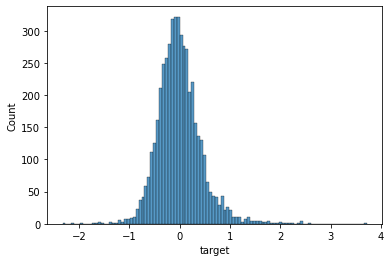

In [66]:
#残差のヒストグラム
#平均＝０の正規分布っぽくなってる
sns.histplot(x=y_residual_test_2)

In [71]:
lr=LinearRegression()
lr.fit(x_train_medinc.values.reshape(-1,1), y_train)
y_test_pred_lr = lr.predict(x_test_medinc)

In [72]:
print(mean_squared_error(y_test, y_test_pred_lr, squared=False))

0.7246754518906384


In [74]:
lgbm_2 = gbm.LGBMRegressor()
lgbm_2.fit(x_train_medinc.values.reshape(-1,1), y_train)
y_test_pred_lgbm = lgbm_2.predict(x_test_medinc)

In [75]:
print(mean_squared_error(y_test, y_test_pred_lgbm, squared=False))

0.7277442522251759


In [ ]:
rscv=RandomizedSearchCV()